# <span style="color:#4682B4;font-family:Optima;font-size:30pt">Analysis of PTMs in their structural context using the StructureMap and AlphaMap Python packages </span>

Last Update: BG 10/26/2023

# Prepare the Environment

In [1]:
# StructureMap functions
import structuremap.utils
from structuremap.processing import (
    download_alphafold_cif, download_alphafold_pae, format_alphafold_data, annotate_accessibility, get_smooth_score,
    perform_enrichment_analysis, perform_enrichment_analysis_per_protein, annotate_proteins_with_idr_pattern, 
    get_extended_flexible_pattern, get_avg_3d_dist, get_avg_1d_dist, get_proximity_pvals, evaluate_ptm_colocalization)
from structuremap.plotting import plot_enrichment, plot_ptm_colocalization
structuremap.utils.set_logger()

# Other packages
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
import tqdm
from itertools import combinations

# Within repo functions
from accessory_functions import *

pd.options.mode.chained_assignment = None

# Download AlphaFold Data

**Note:** The *wkdir* location need to be adjusted for use on another device. Set this to the path of structuremap_analysis.

In [2]:
# Set working directories
wkdir = os.getcwd()

# Make directories
# PAE files
pae_dir = os.path.join(wkdir, 'alphafold_predicted_aligned_errors')
if not os.path.exists(pae_dir):
    os.mkdir(pae_dir)
    
# CIF files
cif_dir = os.path.join(wkdir, 'alphafold_cifs')
if not os.path.exists(cif_dir):
    os.mkdir(cif_dir)
    
# Output dir
output_dir = os.path.join(wkdir, 'output')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

**Note:** I placed the file "230517 Click Cys Site Peptide Roll Up Stucture Map.csv" in a new folder called "./data/courtney_data/". So the full path to the file should be "/Users/bgraham/structuremap_analysis/data/courtney_data/230517 Click Cys Site Peptide Roll Up Stucture Map.csv". You'll need to create the "./data/courtney_data/" folder and place the file in there and the code should run.

In [3]:
# Import raw data
ptm_csv_file = os.path.join(wkdir, "data/231026 Structure Map Cys Lys Peptide Roll-up Combined.csv")
raw_data = pd.read_csv(ptm_csv_file)

# Get uniprot ids
all_uniprot = list(set(raw_data["Accession #"]))
all_uniprot = [uniprot for uniprot in all_uniprot if len(uniprot) == 6] # Remove invalid formats
print(f"{len(all_uniprot)} unique uniprot IDs found.")

1300 unique uniprot IDs found.


In [4]:
# Download CIF files for uniprot ids
valid_proteins_cif, invalid_proteins_cif, existing_proteins_cif = download_alphafold_cif(
    proteins=all_uniprot,
    out_folder=cif_dir)

100%|██████████| 1300/1300 [01:22<00:00, 15.76it/s]

2023-10-26 20:42:38> Valid proteins: 0
2023-10-26 20:42:38> Invalid proteins: 19
2023-10-26 20:42:38> Existing proteins: 1281


In [5]:
# Download PAE files for uniprot ids
valid_proteins_pae, invalid_proteins_pae, existing_proteins_pae = download_alphafold_pae(
    proteins=all_uniprot,
    out_folder=pae_dir)

100%|██████████| 1300/1300 [01:21<00:00, 16.03it/s]

2023-10-26 20:43:59> Valid proteins: 0
2023-10-26 20:43:59> Invalid proteins: 19
2023-10-26 20:43:59> Existing proteins: 1281


In [6]:
# Test if equal protein files available in cif and pae folder
test_identical_ids(f"{cif_dir}/", f"{pae_dir}/")

Number of unique proteins with cif and pae file:  1281


In [7]:
# Output invalid proteins
pd.DataFrame({"invalid_proteins": invalid_proteins_cif}).to_csv("invalid_proteins.csv", index=False)

# Format AlphaFold Data

In [36]:
all_proteins = valid_proteins_cif + existing_proteins_cif
all_proteins = list(set(all_proteins))
all_proteins.remove("Q9Z2Y8") # Throws an error for unknown reasons

In [38]:
%%time
alphafold_annotation = format_alphafold_data(directory=cif_dir, protein_ids=all_proteins)

100%|██████████| 1281/1281 [03:05<00:00,  6.89it/s]


CPU times: user 3min 4s, sys: 1.23 s, total: 3min 6s
Wall time: 3min 6s


In [40]:
# Write results to CSV
alphafold_data_dir = os.path.join(wkdir, 'alphafold_data')
if not os.path.exists(alphafold_data_dir):
    os.mkdir(alphafold_data_dir)

alphafold_annotation.to_csv(os.path.join(alphafold_data_dir, 'alphafold_annotation.csv'), index=False)
# alphafold_annotation = pd.read_csv('alphafold_data/alphafold_annotation.csv')

# Annotate Amino Acid Exposure Metric

### Full Sphere Exposure

In [41]:
%%time
full_sphere_exposure = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=24, 
    max_angle=180, 
    error_dir=pae_dir)

  0%|          | 0/1280 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/structuremap/processing.py:725: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join(
  0%|          | 1/1280 [00:01<35:47,  1.68s/it]/opt/anaconda3/lib/python3.8/site-packages/structuremap/processing.py:725: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join

CPU times: user 33.4 s, sys: 716 ms, total: 34.1 s
Wall time: 35.3 s


In [42]:
# Write results to CSV
full_sphere_exposure.to_csv(os.path.join(alphafold_data_dir, 'full_sphere_exposure.csv'), index=False)
# full_sphere_exposure = pd.read_csv('alphafold_data/full_sphere_exposure.csv')

In [43]:
alphafold_accessibility = alphafold_annotation.merge(
    full_sphere_exposure, how='left', on=['protein_id','AA','position'])

### Half Sphere Exposure

In [44]:
%%time
half_sphere_exposure = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=12, 
    max_angle=70, 
    error_dir=pae_dir)

  0%|          | 0/1280 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/structuremap/processing.py:725: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join(
100%|██████████| 1280/1280 [00:16<00:00, 75.64it/s] 

CPU times: user 15.7 s, sys: 516 ms, total: 16.2 s
Wall time: 17.1 s


In [45]:
half_sphere_exposure.to_csv(os.path.join(alphafold_data_dir, 'half_sphere_exposure.csv'), index=False)
# half_sphere_exposure = pd.read_csv('alphafold_data/half_sphere_exposure.csv')

In [46]:
alphafold_accessibility = alphafold_accessibility.merge(
    half_sphere_exposure, how='left', on=['protein_id','AA','position'])

In [47]:
alphafold_accessibility['high_acc_5'] = np.where(alphafold_accessibility.nAA_12_70_pae <= 5, 1, 0)
alphafold_accessibility['low_acc_5'] = np.where(alphafold_accessibility.nAA_12_70_pae > 5, 1, 0)

In [48]:
alphafold_accessibility.head(10)

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,structure_group,BEND,HELX,STRN,TURN,unstructured,nAA_24_180_pae,nAA_12_70_pae,high_acc_5,low_acc_5
0,A0JNU3,1,M,1,52.21,-3.469,-3.817,-2.641,-4.146,-16.419,...,unstructured,0,0,0,0,1,12,0,1,0
1,A0JNU3,1,A,2,58.54,-3.139,-3.995,-5.341,-4.247,-16.163,...,HELX,0,1,0,0,0,16,0,1,0
2,A0JNU3,1,R,3,73.23,-3.056,-1.807,-0.966,-2.249,-15.832,...,STRN,0,0,1,0,0,43,0,1,0
3,A0JNU3,1,A,4,72.12,-4.387,-4.116,-3.767,-3.019,-15.243,...,HELX,0,1,0,0,0,44,3,1,0
4,A0JNU3,1,M,5,72.90,-6.431,-6.083,-7.280,-5.645,-15.776,...,HELX,0,1,0,0,0,32,0,1,0
5,A0JNU3,1,G,6,78.07,-5.528,-6.729,NaN,-6.350,-15.700,...,BEND,1,0,0,0,0,36,1,1,0
6,A0JNU3,1,P,7,82.21,-4.176,-4.636,-5.199,-5.714,-14.405,...,BEND,1,0,0,0,0,46,0,1,0
7,A0JNU3,1,E,8,90.31,-5.145,-4.750,-5.437,-5.066,-11.241,...,STRN,0,0,1,0,0,75,0,1,0
8,A0JNU3,1,R,9,93.78,-4.232,-4.433,-3.440,-4.236,-8.056,...,STRN,0,0,1,0,0,110,4,1,0
9,A0JNU3,1,R,10,96.27,-5.065,-5.302,-6.597,-5.288,-4.944,...,STRN,0,0,1,0,0,131,2,1,0


In [49]:
alphafold_accessibility.columns

Index(['protein_id', 'protein_number', 'AA', 'position', 'quality',
       'x_coord_c', 'x_coord_ca', 'x_coord_cb', 'x_coord_n', 'y_coord_c',
       'y_coord_ca', 'y_coord_cb', 'y_coord_n', 'z_coord_c', 'z_coord_ca',
       'z_coord_cb', 'z_coord_n', 'secondary_structure', 'structure_group',
       'BEND', 'HELX', 'STRN', 'TURN', 'unstructured', 'nAA_24_180_pae',
       'nAA_12_70_pae', 'high_acc_5', 'low_acc_5'],
      dtype='object')

# Annotate IDRs

In [50]:
alphafold_accessibility_smooth = get_smooth_score(
    alphafold_accessibility, 
    np.array(['quality','nAA_24_180_pae']), 
    [10])

100%|██████████| 1280/1280 [00:01<00:00, 1110.77it/s]


In [51]:
alphafold_accessibility_smooth['IDR'] = np.where(
    alphafold_accessibility_smooth['nAA_24_180_pae_smooth10'] <= 34.27, 1, 0)

# Annotate Short IDRs

In [52]:
alphafold_accessibility_smooth_pattern = annotate_proteins_with_idr_pattern(
    alphafold_accessibility_smooth, 
    min_structured_length = 80, 
    max_unstructured_length = 20)

100%|██████████| 1280/1280 [00:00<00:00, 1543.25it/s]


In [53]:
alphafold_accessibility_smooth_pattern_ext = get_extended_flexible_pattern(
    alphafold_accessibility_smooth_pattern, 
    ['flexible_pattern'], [5])

100%|██████████| 1280/1280 [00:00<00:00, 1309.07it/s]


# Prepare Data for Between PTM Distance Measurements

In [55]:
# Prepare raw data for joining in metadata
ptms = raw_data[['Gene Name', 'Accession #', 'Site', 'p (Corr) ([Ethanol] Vs [Control])', 'FC ([Ethanol] Vs [Control])']]
ptms.columns = ['protein_name', 'protein_id', 'position', 'p_val', 'fold_change']
ptms['ptm'] = 1
ptms['position'] = ptms.position.astype(str)
ptms['AA'] = ptms['position'].str[0]
ptms['protein_AA_position'] = ptms.protein_id.astype(str) + "_" + ptms.position.astype(str)
ptm_list = list(set(ptms['protein_AA_position']))
ptms.head(10)

,protein_name,protein_id,position,p_val,fold_change,ptm,AA,protein_AA_position
0,Psmc3,O88685,K128,1.626730e-11,-291327.560,1,K,O88685_K128
1,Eef1e1,Q9D1M4,K138,3.804150e-13,-210535.000,1,K,Q9D1M4_K138
2,Gpi,P06745,K366,8.870830e-10,-204922.400,1,K,P06745_K366
3,Nme1,P15532,K124,5.513430e-12,-94431.680,1,K,P15532_K124
4,Elovl5,Q8BHI7,K108,4.156150e-09,-85371.440,1,K,Q8BHI7_K108
5,Xdh,Q00519,K629,3.566140e-09,-72213.470,1,K,Q00519_K629
6,RTRAF,Q9CQE8,K72,1.992250e-12,-64799.457,1,K,Q9CQE8_K72
7,Tpp2,Q64514,K1080,3.913480e-12,-33620.066,1,K,Q64514_K1080
8,Cct2,P80314,K522,6.774370e-13,-26961.865,1,K,P80314_K522
9,Pfkfb1,P70266,K118,2.058890e-12,-16832.094,1,K,P70266_K118


In [56]:
# Assign p-values and fold_change to protein_AA_position
protein_name_dict = {key: value for key, value in zip(ptms['protein_id'], ptms['protein_name'])}
p_val_dict = {key: value for key, value in zip(ptms['protein_AA_position'], ptms['p_val'])}
fold_change_dict = {key: value for key, value in zip(ptms['protein_AA_position'], ptms['fold_change'])}

In [57]:
alphafold_accessibility_smooth_pattern_ext['position'] = alphafold_accessibility_smooth_pattern_ext.position.astype(str)
alphafold_c_and_k = alphafold_accessibility_smooth_pattern_ext[(alphafold_accessibility_smooth_pattern_ext["AA"] == "C") | (alphafold_accessibility_smooth_pattern_ext["AA"] == "K")]
alphafold_c_and_k.head(5)

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,unstructured,nAA_24_180_pae,nAA_12_70_pae,high_acc_5,low_acc_5,quality_smooth10,nAA_24_180_pae_smooth10,IDR,flexible_pattern,flexible_pattern_extended_5
39,A0JNU3,1,K,40,94.72,8.580,7.231,6.376,7.322,0.784,...,0,102,3,1,0,94.169524,93.428571,0,0,0
78,A0JNU3,1,C,79,95.76,-1.883,-2.329,-2.106,-1.630,14.186,...,0,120,8,0,1,94.766190,113.285714,0,0,0
134,A0JNU3,1,K,135,95.12,-6.167,-7.464,-8.041,-8.434,-4.411,...,0,151,8,0,1,97.138095,170.476190,0,0,0
172,A0JNU3,1,C,173,98.78,2.193,1.187,1.388,-0.180,0.145,...,0,210,14,0,1,96.782381,169.523810,0,0,0
187,A0JNU3,1,K,188,98.30,12.444,11.256,11.035,10.041,8.110,...,0,160,7,0,1,97.255238,147.000000,0,0,0


<AxesSubplot:>

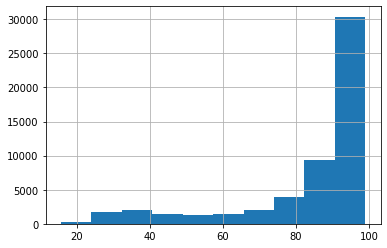

In [58]:
alphafold_c_and_k['quality'].hist()

# 3D Distance Between PTMs

This is custom code to generate the final data set we can use for downstream analysis.

In [59]:
# Function adapted from https://github.com/MannLabs/structuremap/blob/main/structuremap/processing.py#L320
def get_3d_dist(
    coordinate_array_1: np.ndarray,
    coordinate_array_2: np.ndarray) -> float:
    """
    Function to get the distance between two coordinates in 3D space.
    Input are two coordinate arrays and two respective indices that specify
    for which points in the coordinate arrays the distance should be calculated.

    Parameters
    ----------
    coordinate_array_1 : np.ndarray
        Array of 3D coordinates.
        Must be 3d, e.g. np.float64[:,3]
    coordinate_array_2 : np.ndarray
        Array of 3D coordinates.
        Must be 3d, e.g. np.float64[:,3]
    idx_1 : int
        Integer to select an index in coordinate_array_1.
    idx_2 : int
        Integer to select an index in coordinate_array_2.

    Returns
    -------
    : float
        Distance between the two selected 3D coordinates.
    """
    dist = np.sqrt(
        (coordinate_array_1[0] - coordinate_array_2[0])**2 + 
        (coordinate_array_1[1] - coordinate_array_2[1])**2 + 
        (coordinate_array_1[2] - coordinate_array_2[2])**2)
    
    return(dist)


# Target Data Set Generation

In [62]:
# Get protein_ids and ptms to loop through
proteins_of_interest = list(set(alphafold_c_and_k.protein_id))

# Empty data frame to store all pairwise distances
all_pairwise_distances_df = pd.DataFrame()

# Loop through all proteins
for i, prot_of_interest in enumerate(proteins_of_interest, 1):
    
    print(f"Protein {prot_of_interest} ({i}/{len(proteins_of_interest)})...")
    
    # Subset the data frame by protein and extract PTMs of interest
    protein_df = alphafold_c_and_k[(alphafold_c_and_k.protein_id == prot_of_interest)]
    protein_df["AA_position"] = protein_df.AA + protein_df.position

    # Get the combinations of PTMs to measure between-PTM distances
    # Example: Three sites of K66, K70, K99 would become [(K66, K70), (K66, K99), (K70, K99)]
    pairwise_combinations = list(set(combinations(protein_df.AA_position, 2)))

    # Empty data frame to store protein-ptm-specific distances
    for aa_pair in pairwise_combinations:
        #print(aa_pair)

        # Get proteins to calculate distance between
        aa1, aa2 = sorted(aa_pair) # Sorting to consistently get C-K (and no K-C)
        
        # Looking for K-to-C or C-to-K distances (index [0] is looking for AA type)
        if aa1[0] != aa2[0]:
            
            # Get protein1 3D coordinates
            c_df = protein_df[protein_df['AA_position'] == aa1]
            c_coords = c_df[["x_coord_ca", "y_coord_ca", "z_coord_ca"]].to_numpy()[0]

            # Get protein2 3D coordinates
            k_df = protein_df[protein_df['AA_position'] == aa2]
            k_coords = k_df[["x_coord_ca", "y_coord_ca", "z_coord_ca"]].to_numpy()[0]

            # Calculate 3D distance
            dist_3d = get_3d_dist(c_coords, k_coords)
            
            # Determine if either AA is a PTM
            c_id = f"{prot_of_interest}_{aa1}"
            c_ptm = 1 if c_id in ptm_list else 0
            k_id = f"{prot_of_interest}_{aa2}"
            k_ptm = 1 if k_id in ptm_list else 0
            
            # Determine PTM grouping
            # Group 0: 0 PTMS
            # Group 1: C PTM = 0, K PTM = 1
            # Group 1: C PTM = 1, K PTM = 0
            # Group 3: Both PTMs
            ptm_grouping = 0
            if (c_ptm == 0) & (k_ptm == 0):
                ptm_grouping = 0
            elif (c_ptm == 0) & (k_ptm == 1):
                ptm_grouping = 1
            elif (c_ptm == 1) & (k_ptm == 0):
                ptm_grouping = 2
            elif (c_ptm == 1) & (k_ptm == 1):
                ptm_grouping = 3
            
            # Get p-value and fold-change of ptms
            # Cystines
            c_p_val = np.nan
            c_fold_change = np.nan
            if c_ptm:
                c_p_val = p_val_dict[f"{prot_of_interest}_{aa1}"]
                c_fold_change = fold_change_dict[f"{prot_of_interest}_{aa1}"]
            
            # Lysines
            k_p_val = np.nan
            k_fold_change = np.nan
            if k_ptm:
                k_p_val = p_val_dict[f"{prot_of_interest}_{aa2}"]
                k_fold_change = fold_change_dict[f"{prot_of_interest}_{aa2}"]
            
            # Format results in df
            distance_results = pd.DataFrame({
                "gene_name": [protein_name_dict[prot_of_interest]],
                "accession_num": [prot_of_interest],
                "c_position": [aa1],
                "c_ptm": [c_ptm],
                "c_p_val": [c_p_val],
                "c_fold_change": [c_fold_change],
                "c_quality_score": [float(c_df.quality)],
                "c_x_coord": [float(c_df.x_coord_ca)],
                "c_y_coord": [float(c_df.y_coord_ca)],
                "c_z_coord": [float(c_df.z_coord_ca)],
                "c_nAA_24_180_pae": [int(c_df.nAA_24_180_pae)], 
                "c_nAA_12_70_pae": [int(c_df.nAA_12_70_pae)], 
                "k_position": [aa2],
                "k_ptm": [k_ptm],
                "k_p_val": [k_p_val],
                "k_fold_change": [k_fold_change],
                "k_quality_score": [float(k_df.quality)],
                "k_x_coord": [float(k_df.x_coord_ca)],
                "k_y_coord": [float(k_df.y_coord_ca)],
                "k_z_coord": [float(k_df.z_coord_ca)],
                "k_nAA_24_180_pae": [int(k_df.nAA_24_180_pae)], 
                "k_nAA_12_70_pae": [int(k_df.nAA_12_70_pae)],
                "ptm_grouping": [ptm_grouping],
                "total_ptms": [c_ptm + k_ptm],
                "dist_3d": [round(dist_3d, 3)]
            })

            # Append results
            all_pairwise_distances_df = pd.concat([all_pairwise_distances_df, distance_results])

# Output distance measures
all_pairwise_distances_df = all_pairwise_distances_df.drop_duplicates()
all_pairwise_distances_df.to_csv(
    os.path.join(output_dir, f"{pd.Timestamp.now().strftime('%Y%m%d')}_ptm_pairwise_distances.csv", index=False)
)

Protein Q61990 (1/1280)...
Protein Q76MZ3 (2/1280)...
Protein Q8VCR2 (3/1280)...
Protein Q99JY3 (4/1280)...
Protein Q03265 (5/1280)...
Protein Q9DCU9 (6/1280)...
Protein Q91WK5 (7/1280)...
Protein Q9WV70 (8/1280)...
Protein Q91XF0 (9/1280)...
Protein Q8BXV2 (10/1280)...
Protein Q99LB7 (11/1280)...
Protein Q8CIM7 (12/1280)...
Protein Q8CHT0 (13/1280)...
Protein O88533 (14/1280)...
Protein Q9QZE7 (15/1280)...
Protein P97452 (16/1280)...
Protein Q9WVA2 (17/1280)...
Protein Q8BM55 (18/1280)...
Protein O88696 (19/1280)...
Protein P05063 (20/1280)...
Protein P32261 (21/1280)...
Protein Q9CPP6 (22/1280)...
Protein Q8CC86 (23/1280)...
Protein P20152 (24/1280)...
Protein Q3URS9 (25/1280)...
Protein Q8BMG8 (26/1280)...
Protein Q9DBT9 (27/1280)...
Protein Q6PDG5 (28/1280)...
Protein Q8CGK3 (29/1280)...
Protein Q9CZN7 (30/1280)...
Protein Q91VD9 (31/1280)...
Protein Q60759 (32/1280)...
Protein Q00731 (33/1280)...
Protein A3KGB4 (34/1280)...
Protein Q9CQR2 (35/1280)...
Protein Q8K2Z2 (36/1280)...
P

Protein Q61820 (288/1280)...
Protein Q9CZ42 (289/1280)...
Protein O55137 (290/1280)...
Protein P00920 (291/1280)...
Protein P63028 (292/1280)...
Protein P23492 (293/1280)...
Protein Q9D6Y9 (294/1280)...
Protein Q3U2A8 (295/1280)...
Protein Q61694 (296/1280)...
Protein Q9CTH6 (297/1280)...
Protein O89051 (298/1280)...
Protein P25688 (299/1280)...
Protein P37040 (300/1280)...
Protein P60670 (301/1280)...
Protein Q9D4V3 (302/1280)...
Protein P51855 (303/1280)...
Protein Q05421 (304/1280)...
Protein Q9JLN9 (305/1280)...
Protein P52825 (306/1280)...
Protein Q9JJK2 (307/1280)...
Protein Q9DBG6 (308/1280)...
Protein Q9DBA8 (309/1280)...
Protein Q8VEM8 (310/1280)...
Protein P49429 (311/1280)...
Protein Q9CVB6 (312/1280)...
Protein Q9QZK2 (313/1280)...
Protein Q9ES97 (314/1280)...
Protein P03930 (315/1280)...
Protein Q9D855 (316/1280)...
Protein P54869 (317/1280)...
Protein Q9D0M1 (318/1280)...
Protein Q8VC30 (319/1280)...
Protein Q9CZU6 (320/1280)...
Protein P31649 (321/1280)...
Protein Q9DC50

Protein P47962 (572/1280)...
Protein P19536 (573/1280)...
Protein F6ZDS4 (574/1280)...
Protein Q8K202 (575/1280)...
Protein Q91XE0 (576/1280)...
Protein Q9CXW2 (577/1280)...
Protein O54692 (578/1280)...
Protein P00186 (579/1280)...
Protein Q8VCC1 (580/1280)...
Protein Q8R164 (581/1280)...
Protein O55023 (582/1280)...
Protein P42125 (583/1280)...
Protein Q8VEK3 (584/1280)...
Protein Q9DCY0 (585/1280)...
Protein Q9CZL5 (586/1280)...
Protein P35564 (587/1280)...
Protein Q8CAS9 (588/1280)...
Protein Q99LC3 (589/1280)...
Protein Q61133 (590/1280)...
Protein Q8JZZ0 (591/1280)...
Protein Q8K274 (592/1280)...
Protein P41216 (593/1280)...
Protein P47911 (594/1280)...
Protein Q9CWE0 (595/1280)...
Protein Q71RI9 (596/1280)...
Protein Q9EP89 (597/1280)...
Protein Q91VR5 (598/1280)...
Protein Q9D6M3 (599/1280)...
Protein Q8R3Q6 (600/1280)...
Protein Q6NZJ6 (601/1280)...
Protein P70398 (602/1280)...
Protein Q9JKV1 (603/1280)...
Protein Q9CYK1 (604/1280)...
Protein Q9D8X1 (605/1280)...
Protein P56657

Protein Q61102 (855/1280)...
Protein Q8R035 (856/1280)...
Protein Q9Z1P6 (857/1280)...
Protein P35486 (858/1280)...
Protein O35643 (859/1280)...
Protein Q8BWU8 (860/1280)...
Protein Q14C51 (861/1280)...
Protein P08032 (862/1280)...
Protein P85094 (863/1280)...
Protein Q9WVM8 (864/1280)...
Protein P22599 (865/1280)...
Protein Q99JB2 (866/1280)...
Protein Q62318 (867/1280)...
Protein Q91WU5 (868/1280)...
Protein P16460 (869/1280)...
Protein Q99L47 (870/1280)...
Protein P00493 (871/1280)...
Protein Q9QZ85 (872/1280)...
Protein O35488 (873/1280)...
Protein Q8BH95 (874/1280)...
Protein P99025 (875/1280)...
Protein Q9CQV8 (876/1280)...
Protein O54909 (877/1280)...
Protein Q8R3D1 (878/1280)...
Protein P48036 (879/1280)...
Protein Q3TC72 (880/1280)...
Protein Q8BUV3 (881/1280)...
Protein Q61316 (882/1280)...
Protein Q8BL99 (883/1280)...
Protein O70252 (884/1280)...
Protein Q8K010 (885/1280)...
Protein Q8BH55 (886/1280)...
Protein Q9Z2U1 (887/1280)...
Protein P02769 (888/1280)...
Protein Q9DBG5

Protein Q8BMF3 (1133/1280)...
Protein Q6NXM2 (1134/1280)...
Protein Q9DAW9 (1135/1280)...
Protein Q9WV68 (1136/1280)...
Protein Q9CW42 (1137/1280)...
Protein P26039 (1138/1280)...
Protein Q07076 (1139/1280)...
Protein Q8K215 (1140/1280)...
Protein P68372 (1141/1280)...
Protein Q7TSG3 (1142/1280)...
Protein Q9EPU0 (1143/1280)...
Protein Q9DC69 (1144/1280)...
Protein A0JNU3 (1145/1280)...
Protein Q99MR8 (1146/1280)...
Protein O08715 (1147/1280)...
Protein Q5EBG8 (1148/1280)...
Protein Q91WS0 (1149/1280)...
Protein Q99LX0 (1150/1280)...
Protein P80317 (1151/1280)...
Protein Q01768 (1152/1280)...
Protein Q64520 (1153/1280)...
Protein Q8C0L9 (1154/1280)...
Protein Q9D665 (1155/1280)...
Protein Q8BP67 (1156/1280)...
Protein Q62452 (1157/1280)...
Protein O35684 (1158/1280)...
Protein Q8BFW7 (1159/1280)...
Protein O55222 (1160/1280)...
Protein P52840 (1161/1280)...
Protein O55060 (1162/1280)...
Protein O08749 (1163/1280)...
Protein P19639 (1164/1280)...
Protein P29758 (1165/1280)...
Protein Q9